In [1]:
import pandas as pd
import numpy as np
import h5py
import os
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder, CIFAR10
from torchvision import transforms
from torch import nn, optim
from collections import OrderedDict
from sklearn.model_selection import train_test_split

import pickle
from PIL import Image
import requests
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
import seaborn as sn
from sklearn import preprocessing

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

torch.manual_seed(1) # Set manual seed

In [2]:
#Definir variables globales
ancho = 32
alto = 32
canales = 3
pixeles = ancho*alto*canales
cantidadClases = 10
clases = ['Avión', 'Carro', 'Pájaro', 'Gato', 'Ciervo', 'Perro', 'Rana', 'Caballo', 'Barco', 'Camión']
batchSize = 100
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]
current_dir = os.getcwd()

In [3]:
#Transformaciones entrenamiento
train_transform = transforms.Compose(
  [transforms.Resize((ancho, alto)), # Resize the image in a 32X32 shape
  transforms.RandomRotation(20), # Randomly rotate some images by 20 degrees
  transforms.RandomHorizontalFlip(0.1), # Randomly horizontal flip the images
  transforms.ColorJitter(
    brightness = 0.1, # Randomly adjust color jitter of the images
    contrast = 0.1, 
    saturation = 0.1), 
  transforms.RandomAdjustSharpness(
    sharpness_factor = 2,
    p = 0.1), # Randomly adjust sharpness
  transforms.ToTensor(),   # Converting image to tensor
  transforms.Normalize(mean, std), # Normalizing with standard mean and standard deviation
  transforms.RandomErasing(p=0.75,scale=(0.02, 0.1),value=1.0, inplace=False)]
)

#Transformaciones prueba
test_transform = transforms.Compose(
  [transforms.Resize((ancho,alto)),
  transforms.ToTensor(),
  transforms.Normalize(mean, std)]
  )

#Datos de Entrenamiento
dataset_path = os.path.join(current_dir, 'dataset','train')
trainset = CIFAR10(root=dataset_path, train=True, download=False, transform=train_transform)
trainloader = DataLoader(trainset, batch_size=batchSize, shuffle=True)

#Datos de Prueba
testset_path = os.path.join(current_dir, 'dataset','test')
testset = CIFAR10(root=testset_path,train=False, download=False, transform=test_transform)
testloader = DataLoader(testset, batch_size=batchSize, shuffle=True)


In [4]:
#Funciones Auxiliares para graficar 

#Mostrar imágen del dataset
def show_data(img):
  try:
    plt.imshow(img[0])
  except Exception as e:
    print(e)
  print(img[0].shape, img[0].permute(1,2,0).shape)
  plt.imshow(img[0].permute(1,2,0))
  plt.title('y = '+ str(img[1]))
  plt.show()

# We need to convert the images to numpy arrays as tensors are not compatible with matplotlib.
def im_convert(tensor):
  img = tensor.cpu().clone().detach().numpy() #
  img = img.transpose(1, 2, 0)
  img = img * np.array(tuple(mean)) + np.array(tuple(std))
  img = img.clip(0, 1) # Clipping the size to print the images later
  return img

def view_classify(img, ps):
  ps = ps.data.numpy().squeeze()
  fig, (ax1, ax2) = plt.subplots(figsize=(16,13), ncols=2)
  ax1.imshow(img.numpy().transpose((1, 2, 0)))
  ax1.axis('off')
  ax2.barh(np.arange(cantidadClases), ps)
  ax2.set_aspect(0.1)
  ax2.set_yticks(np.arange(cantidadClases))
  ax2.set_yticklabels(clases, size='medium');
  ax2.set_title('Probabilidad de las Clases')
  ax2.set_xlim(0, 1.1)

  plt.tight_layout()
  
def plot_confusion_matrix(cm, class_names, title="Matriz de Confusión"):
  fig, ax = plt.subplots(figsize=(6, 6))
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  plt.colorbar(cax)

  for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='black')

  ax.set_xticks(np.arange(len(class_names)))
  ax.set_yticks(np.arange(len(class_names)))
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  plt.xlabel('Predicción')
  plt.ylabel('Real')
  plt.title(title)
  plt.show()

In [5]:
class Network(nn.Module):
  def __init__(self):
    out_1 = 32
    out_2 = 64
    out_3 = 128
    p = 0.5
    
    super(Network, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
    self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
    self.conv1_bn = nn.BatchNorm2d(out_1)
    self.drop_conv = nn.Dropout(p=0.2)
    
    self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
    self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
    self.conv2_bn = nn.BatchNorm2d(out_2)
    
    self.cnn3 = nn.Conv2d(in_channels = out_2, out_channels = out_3, kernel_size = 5, padding = 2)
    self.maxpool3 = nn.MaxPool2d(kernel_size = 2)
    self.conv3_bn = nn.BatchNorm2d(out_3)
    
    # Hidden layer 1
    self.fc1 = nn.Linear(out_3 * 4 * 4, 1000) 
    self.drop = nn.Dropout(p=p)
    self.fc1_bn = nn.BatchNorm1d(1000)
    
    # Hidden layer 2
    self.fc2 = nn.Linear(1000, 1000)
    self.fc2_bn = nn.BatchNorm1d(1000)

    # Hidden layer 3
    self.fc3 = nn.Linear(1000, 1000)
    self.fc3_bn = nn.BatchNorm1d(1000)
    
    # Hidden layer 4
    self.fc4 = nn.Linear(1000, 1000)
    self.fc4_bn = nn.BatchNorm1d(1000)
    
    # Final layer
    self.fc5 = nn.Linear(1000, 10)
    self.fc5_bn = nn.BatchNorm1d(10)
      
  def forward(self, x):
      
    x = self.cnn1(x)
    x = self.conv1_bn(x)
    x = self.maxpool1(x)
    x = self.drop_conv(x)
    
    x = self.cnn2(x)
    x = self.conv2_bn(x)
    x = torch.relu(x)
    x = self.maxpool2(x)
    x = self.drop_conv(x)
    
    x = self.cnn3(x)
    x = self.conv3_bn(x)
    x = torch.relu(x)
    x = self.maxpool3(x)
    x = self.drop_conv(x)
    
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = self.fc1_bn(x)
    
    x = F.relu(self.drop(x))
    x = self.fc2(x)
    x = self.fc2_bn(x)
    
    x = F.relu(self.drop(x))
    x = self.fc3(x)
    x = self.fc3_bn(x)
    
    x = F.relu(self.drop(x))
    x = self.fc4(x)
    x = self.fc4_bn(x)

    x = F.relu(self.drop(x))
    x = self.fc5(x)
    x = self.fc5_bn(x)
    
    return(x)

In [16]:
#Definir la tasa de entrenamiento y la función para el cálculo de pérdidas
model = Network()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum = 0.2)
image, label = next(iter(trainloader))

#Definir la arquitectura del entrenamiento

epochs = 200
steps = 0
train_losses, test_losses = [], []
precisions, recalls, f1_scores, accus, avg_specificities = [], [], [], [], []


Epoch: 1/2..  Training Loss: 1.723..  Test Loss: 1.458..  Test Accuracy: 0.470 Weighted Precision: 0.466 Weighted Recall: 0.470 Weighted F1 Score: 0.464 Average Specificity: 0.941

Epoch: 2/2..  Training Loss: 1.450..  Test Loss: 1.272..  Test Accuracy: 0.546 Weighted Precision: 0.539 Weighted Recall: 0.546 Weighted F1 Score: 0.540 Average Specificity: 0.950

Matriz de Confusión


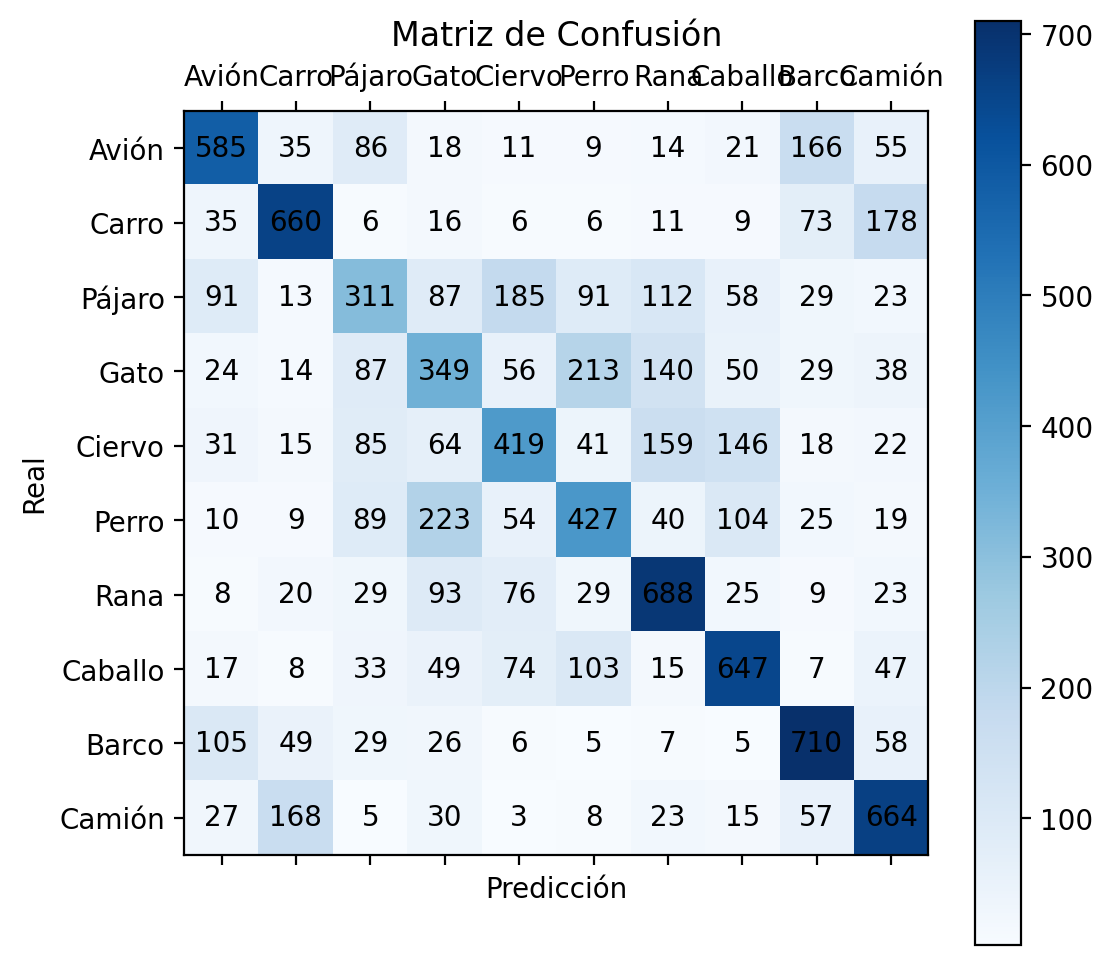

In [17]:
for e in range(epochs):
  running_loss = 0
  for images,labels in trainloader:
    optimizer.zero_grad()
    log_ps = model(images)
    loss = criterion(log_ps,labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
        
  else:
    test_loss = 0
    accuracy = 0
    all_labels = []
    all_preds = []
    
    # Turn off gradients for validation
    with torch.no_grad():
      for images, labels in testloader:
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)

        ps = torch.softmax(log_ps, dim=1)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        # Save labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(top_class.cpu().numpy())
  
    # Calcular matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)
    
    num_classes = cm.shape[0]
    specificities = []
    for i in range(num_classes):
      tp = cm[i, i]
      fn = cm[i, :].sum() - tp
      fp = cm[:, i].sum() - tp
      tn = cm.sum() - (tp + fn + fp)
      specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
      
      specificities.append(specificity)

    # Calcular métricas ponderadas
    precision_weighted = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall_weighted = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    accuracy = accuracy_score(all_labels, all_preds)
    avg_specificity = np.mean(specificities)
    
    model.train()
    train_losses.append(running_loss / len(trainloader))
    test_losses.append(test_loss / len(testloader))
    precisions.append(precision_weighted)
    recalls.append(recall_weighted)
    f1_scores.append(f1_weighted)
    avg_specificities.append(avg_specificity)
    accus.append(accuracy)

    # Print metricas
    print("\nEpoch: {}/{}.. ".format(e + 1, epochs),
      "Training Loss: {:.3f}.. ".format(train_losses[-1]),
      "Test Loss: {:.3f}.. ".format(test_losses[-1]),
      "Test Accuracy: {:.3f}".format(accuracy),
      "Weighted Precision: {:.3f}".format(precision_weighted),
      "Weighted Recall: {:.3f}".format(recall_weighted),
      "Weighted F1 Score: {:.3f}".format(f1_weighted),
      "Average Specificity: {:.3f}".format(avg_specificity))

    
    # Graficar matriz
    if e == epochs - 1:
      print("\nMatriz de Confusión")
      plot_confusion_matrix(cm, clases, title="Matriz de Confusión")

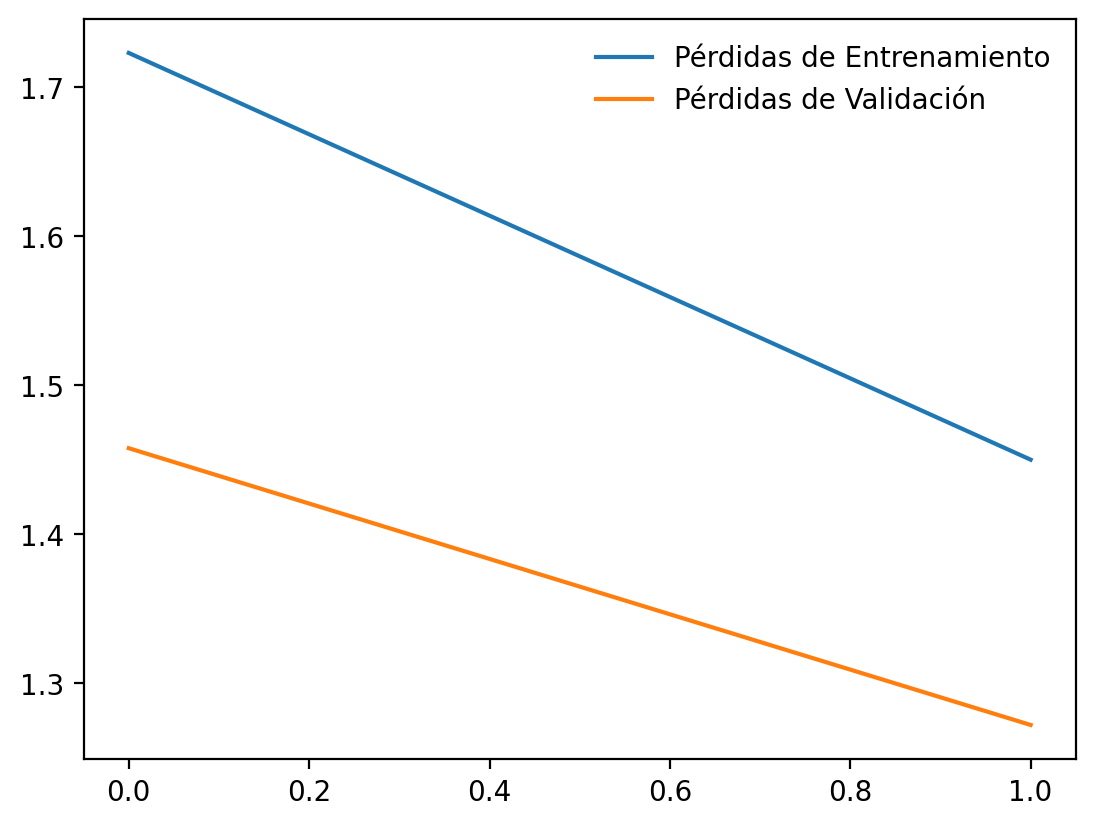

In [18]:
#Graficar pérdidas de entrenamiento y validación
plt.plot(train_losses, label='Pérdidas de Entrenamiento')
plt.plot(test_losses, label='Pérdidas de Validación')
plt.legend(frameon=False)

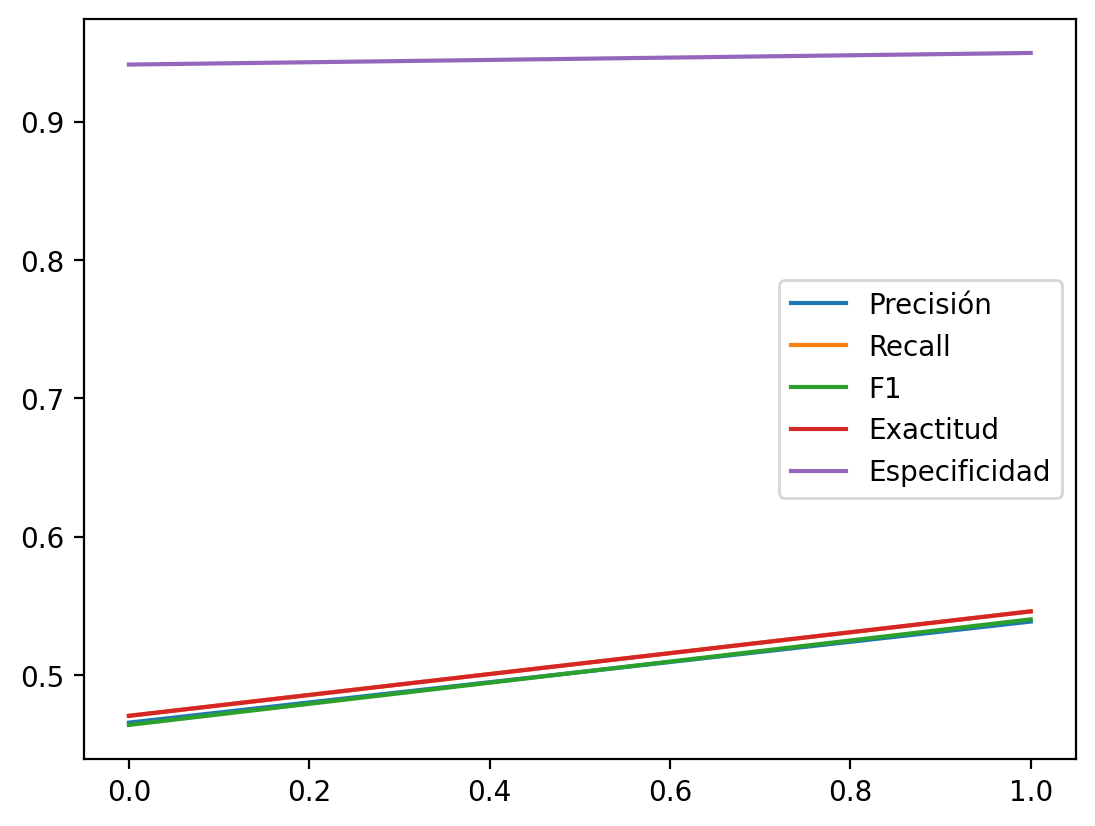

In [19]:
#Graficar los indicadores de validación
plt.plot(precisions, label='Precisión')
plt.plot(recalls, label='Recall')  
plt.plot(f1_scores, label='F1')  
plt.plot(accus, label='Exactitud')  
plt.plot(avg_specificities, label='Especificidad')  
plt.legend(frameon=True)

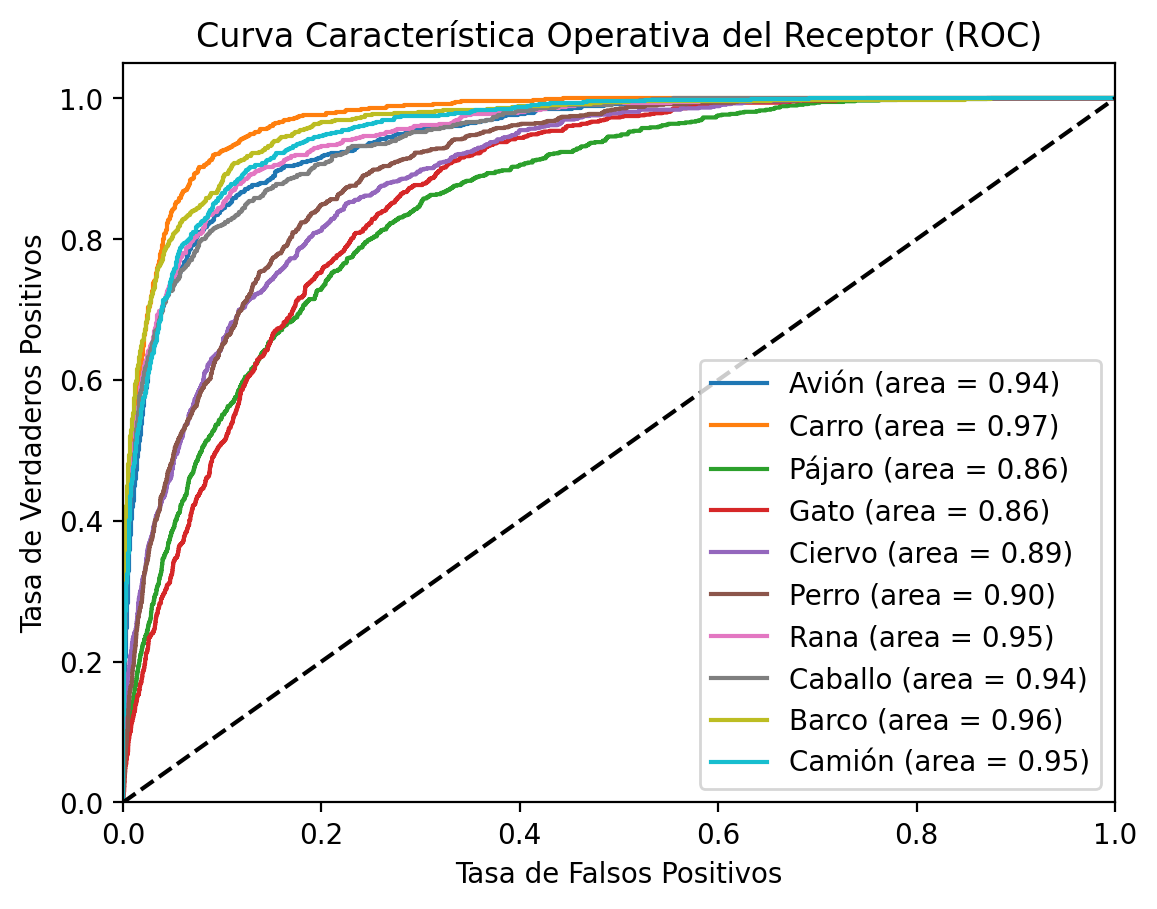

Area Bajo la Curva (AUC): 0.92


In [20]:
#Calcular y graficar ROC y AUC
all_labels = []
all_probs = []

model.eval()
with torch.no_grad():
  for images, labels in testloader:
    log_ps = model(images)
    ps = torch.softmax(log_ps, dim=1)
    
    all_labels.extend(labels.cpu().numpy())
    all_probs.extend(ps.cpu().numpy())

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calcular ROC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(cantidadClases):
  fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar ROC para cada clase
plt.figure()
for i in range(cantidadClases):
  plt.plot(fpr[i], tpr[i], label='{} (area = {:.2f})'.format(clases[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva Característica Operativa del Receptor (ROC)')
plt.legend(loc="lower right")
plt.show()

# Calcular AUC
overall_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
print("Area Bajo la Curva (AUC): {:.2f}".format(overall_auc))